# A benchmark of sorting functions

*Hans E Plesser, 23 September 2014; revised 9 October 2014*

## Introduction

We provide here a benchmark for several sorting functions implemented in Python as well as Python's built-in `sorted()` function for reference. All functions operate on Python lists of integers or floats and return sorted copies of the input data as Python lists.

This revised version includes several variants of bubble sort, selection sort and quicksort, as well as "splitsort".

### Additional files required

For this notebook to work properly, the following files are required in your Python path:

* `sorting_algorithms.py`
* `function_timer.py`

## System information

We will first provide documentation of our experimental setup, i.e., version information from our source code repository, information about our Python installation and our computer. This is followed by tests to ascertain the correctness of all algorithms tested, before we proceed to the benchmarks.

### Source code

In [1]:
pwd

u'/Users/plesser/Courses/INF200/H2015/NMBU_INF200_H15/Lectures/L11_20151123'

In [2]:
!git branch

* master


In [3]:
!git ls-tree --abbrev master 

In [4]:
!git status -s

 M ../L10_20151116/INF200_H15_L10.ipynb
?? ../L09_20151109/nbconvert_patching.diff
?? ../L10_20151116/INF200_H15_L10.tex
?? ./


Our source code is thus committed in its entirety. Note that the version of this notebook is the one that we just opened. If we execute any code in this notebook and save, we will get a different `.ipynb` file.

### Python configuration

In [5]:
import sys
import os
import numpy
import matplotlib

In [6]:
sys.version

'2.7.10 |Anaconda 2.4.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]'

In [7]:
numpy.version.version

'1.10.1'

In [8]:
matplotlib.__version__

'1.4.3'

### Computer information

This notebook was originally written and run on a mid-2010 Apple MacBook Pro with a 2.53 GHz Intel Core i5 two-core processor with 256 KiB L2 cache memory per core and 3 MiB shared L3 memory, and 8 GiB DDR3 RAM clocked at 1067 MHz, running Apple OSX 10.9.5.

In [9]:
import platform
import subprocess

def get_processor_info():
    """
    Return CPU information in platform-independent way.
    
    This code was posted by Phil L. on 
    http://stackoverflow.com/questions/4842448/getting-processor-information-in-python
    """
    
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        command = ['/usr/sbin/sysctl', '-n', 'machdep.cpu.brand_string']
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo | grep 'model name'"
        return subprocess.check_output(command, shell=True).strip()
    else:
        return None

#### Operating system

In [10]:
print platform.platform()

Darwin-14.5.0-x86_64-i386-64bit


#### Processor information

In [11]:
print get_processor_info()

Intel(R) Core(TM) i5-5287U CPU @ 2.90GHz


## Preparations

### Imports and settings

Import random module and define seed for reproducible results. We also import Matplotlib here and enforce inlined figures, and the FunctionTimer provided by Plesser.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
from function_timer import FunctionTimer

random.seed(1234567)

%matplotlib inline

plt.rcParams['savefig.dpi'] = 120          # reduce if figures are too wide
plt.rcParams['figure.figsize'] = (8., 3.)

### The Functions to Benchmark

In [13]:
from sorting_algorithms import bubble_sort, bubble_sort_swap_equals
from sorting_algorithms import selection_sort, selection_sort_immediate_swap
from sorting_algorithms import quicksort, quicksort_wiki, splitsort

algos = [bubble_sort, bubble_sort_swap_equals, selection_sort, selection_sort_immediate_swap,
         quicksort, quicksort_wiki, splitsort, sorted]

The sorting_algorithms module has tests built into its main section. We run those tests here to make sure the code is in good shape.

In [14]:
%run sorting_algorithms

64 of 64 tests passed: Congratulations!


### A function generating random lists

In [15]:
def random_list(length, max_value=1e9):
    return [random.randint(0, max_value) for _ in xrange(length)]

## Benchmarks

We were unfortenatly not able to reserve a computer for running these benchmarks undisturbed. They were run while normal office programs were running on the computer during benchmark execution. This should be taken into account in interpreting the data below.

### Manual benchmarks

We start by timing a few cases manually, just to get an idea of what things look like. We use IPythons %timeit magic for this

In [16]:
test_data = random_list(1000)

In [17]:
%timeit bubble_sort(test_data)

1 loops, best of 3: 187 ms per loop


In [18]:
%timeit bubble_sort_swap_equals(test_data)

1 loops, best of 3: 167 ms per loop


In [19]:
%timeit selection_sort(test_data)

10 loops, best of 3: 34.7 ms per loop


In [20]:
%timeit selection_sort_immediate_swap(test_data)

10 loops, best of 3: 106 ms per loop


In [21]:
%timeit selection_sort_idx(test_data)

10 loops, best of 3: 53.1 ms per loop


In [22]:
%timeit quicksort(test_data)

100 loops, best of 3: 4.31 ms per loop


In [23]:
%timeit quicksort_wiki(test_data)

100 loops, best of 3: 3.59 ms per loop


In [24]:
%timeit splitsort(test_data)

100 loops, best of 3: 3.89 ms per loop


In [25]:
%timeit sorted(test_data)

1000 loops, best of 3: 255 µs per loop


We notice that the algorithms appear to differ significantly in speed, with `sorted()` taking a clear lead, almost 600 times faster than `bubble_sort()`.  We shall now explore this in more detail.

### Test data

We want to study the behavior of the sorting algorithms when handling data with different properties. We therefore create several sets of test data:

* lists of random integers
* lists of identical integers
* lists of random integers in ascending order (ie, correctly sorted)
* lists of random integers in descending order (ie, sorted the wrong way around)

In order to keep the overall time required to run the benchmarks limited, and considering that `bubble_sort()` requires about 150 ms already for a list of 1000 elements, we will create a first set of benchmark data with list lengths up to 1024 only.

In [26]:
len_small = [2**n for n in range(1, 11)]
data_small = {'random' : [random_list(length)  for length in len_small],
              'ident'  : [[1] * length         for length in len_small],
              'ascend' : [range(length)        for length in len_small],
              'descend': [range(length, 0, -1) for length in len_small]}

We also prepare a set of larger lists for benchmarking the fastest algorithms with up to $1024^2$ elements, now stepping by factor 4.

In [27]:
len_large = [4**n for n in range(1, 11)]
data_large = {'random' : [random_list(length)  for length in len_large],
              'ident'  : [[1] * length         for length in len_large],
              'ascend' : [range(length)        for length in len_large],
              'descend': [range(length, 0, -1) for length in len_large]}

### Benchmarks on randomly ordered list

We first run the benchmarks on the small datasets, using only the list with randomly ordered data. We convert number to milliseconds immediately.

In [28]:
rt_small_random = {algo.__name__:
                   [1000. * min(FunctionTimer(algo, test_data).auto_timeit(quiet=True))
                    for test_data in data_small['random']]
                   for algo in algos}

We plot the results, both in a linear and a double logarithmic plot.

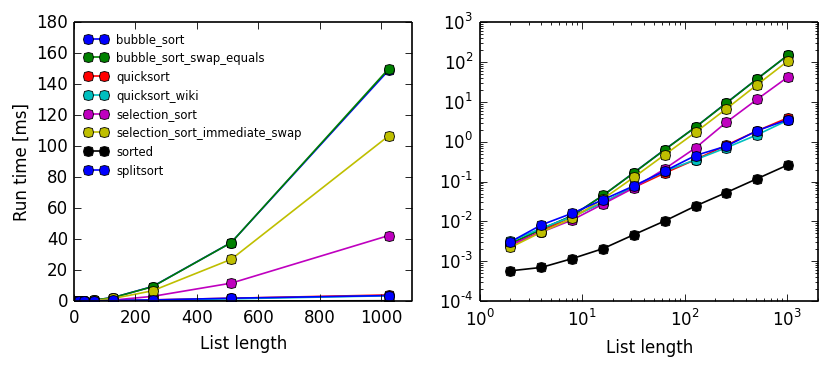

In [29]:
plt.subplot(1,2,1)
for algname, times in sorted(rt_small_random.items()):
    plt.plot(len_small, times, 'o-', label=algname)
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 1100)
plt.ylim(0, 180)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

plt.subplot(1,2,2)
for algname, times in sorted(rt_small_random.items()):
    plt.loglog(len_small, times, 'o-', label=algname)
plt.xlabel('List length')
plt.xlim(1, 2000);

We base our interpretation of the data on the logarithmic plot. The data appear smooth, suggesting that measurements were not influenced significantly by varying background activity on the computer. We observe transition effects for small lists ($<50$), while curves appear rather straight for longer lists. Curves for bubble sort and selection sort are roughly parallel to each other, while curves for quicksort and `sorted()` are parallel to each other, but with a smaller slope. This hints at different scaling behaviors of these two groups of algorithms.

Inspecting the graph for bubble sort, we see that an increase in list length from approximately 100 to 1000 entails an increase in runtime from 1 ms to 100 ms, i.e., a tenfold increase in problem size $N$ leads to a hundredfold increase in runtime $T(N)$. We thus add a line marking $T(N)\sim N^2$ to the figure. We also add a $T(N)\sim N$ line to the plot to see if times scale linearly for quicksort. Both lines are adjusted so that their values match that of the third-last data point in the curve to which they correspond.

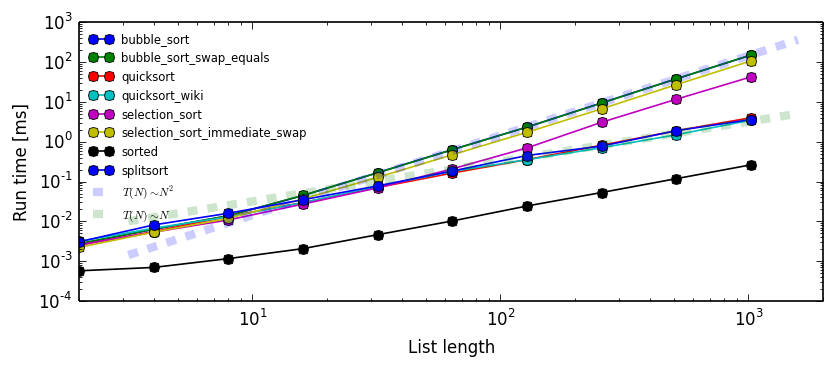

In [30]:
n = np.logspace(0.5, 3.2)
for algname, times in sorted(rt_small_random.items()):
    plt.loglog(len_small, times, 'o-', label=algname)
plt.loglog(n, rt_small_random['bubble_sort'][-3]*(n/len_small[-3])**2, 
           'b--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N^2$')
plt.loglog(n, rt_small_random['quicksort'][-3]*n/len_small[-3], 
           'g--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N$')
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2000)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

The light blue line matches the bubble sort data very well for the last five data points. Thus, bubble sort (and selection sort) appear to follow a quadratic scaling ($T(N)\sim N^2$). The quicksort curve, though, seems possibly somewhat steeper than the dashed green (linear) line. To explore this, we need to benchmark using longer lists.

Note also that selection sort with immediate swapping is clearly slower than selection sort which swaps only once per round, while there are no noticeable differences between the bubble sort varieties. "Splitsort" appears roughly as performant as quicksort.

In [31]:
fast_algos = [quicksort, quicksort_wiki, splitsort, sorted]

rt_large_random = {algo.__name__:
                   [1000. * min(FunctionTimer(algo, test_data).auto_timeit(quiet=True))
                    for test_data in data_large['random']]
                   for algo in fast_algos}

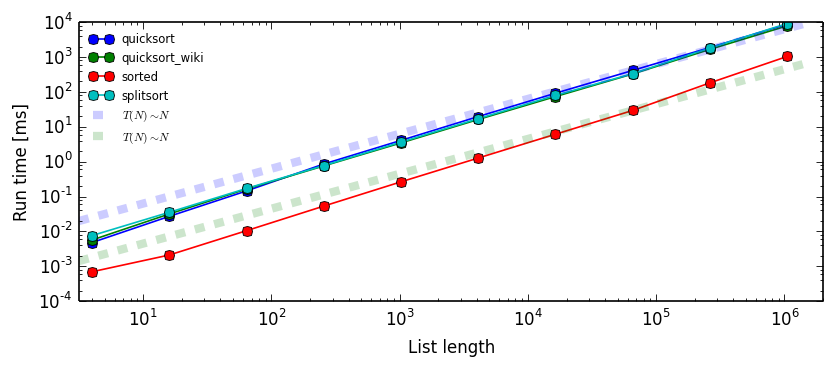

In [32]:
n = np.logspace(0.5, 6.2)
for algname, times in sorted(rt_large_random.items()):
    plt.loglog(len_large, times, 'o-', label=algname)
plt.loglog(n, rt_large_random['quicksort'][-3]*(n/len_large[-3]), 
           'b--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N$')
plt.loglog(n, rt_large_random['sorted'][-3]*n/len_large[-3], 
           'g--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N$')
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2e6)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

We see now rather clearly that the data shows a steeper slope than $T(N)\sim N$, i.e., the algorithms scale worse than linear. From textbooks, we glance that we should expect $T(N)\sim N \ln N$. In the next plot, we therefore plot this relationship.

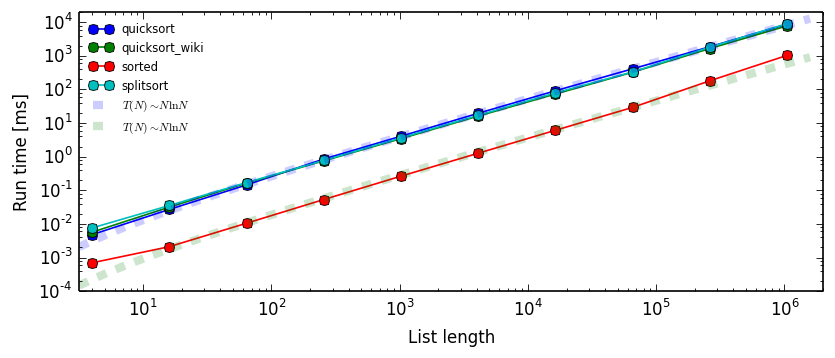

In [33]:
n = np.logspace(0.5, 6.2)
for algname, times in sorted(rt_large_random.items()):
    plt.loglog(len_large, times, 'o-', label=algname)
    
n_ref = len_large[-3]
t_ref = n_ref * np.log(n_ref)
plt.loglog(n, rt_large_random['quicksort'][-3]*n*np.log(n)/t_ref, 
           'b--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N \ln N$')
plt.loglog(n, rt_large_random['sorted'][-3]*n*np.log(n)/t_ref,
           'g--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N \ln N$')
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2e6)
plt.ylim(1e-4, 2e4)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

The $N\ln N$ relationship seems to hold excellently for the quicksort, quicksort wiki and splitsort algorithms, except for very short lists, where special overhead effects may be expected. For `sorted()`, run times appear to increase for the largest problem sizes. Whether this is due to other activity on the computer during the measurement or a genuine effect, would have to be assessed by additional measurements.

On average, the built-in `sorted()` function appears to be about 10 times faster than our quicksort for random data:

In [34]:
print np.mean(np.array(rt_large_random['quicksort']) / np.array(rt_large_random['sorted']))

12.8240727123


### Benchmark for non-random data

We will now explore the performance of the sorting algorithm for non-random data, using small data again. We investigate one type of data at a time.

#### Maximum recursion depth

Our quicksort implementation will recurse once per list element in the worst case. To be able to handle list with 1024 elements, we must therefore increase Python's recursion limit (default: 1000).

In [35]:
sys.setrecursionlimit(1500)

#### Identical values

In [36]:
rt_small_ident = {algo.__name__:
                   [1000. * min(FunctionTimer(algo, test_data).auto_timeit(quiet=True))
                    for test_data in data_small['ident']]
                   for algo in algos}

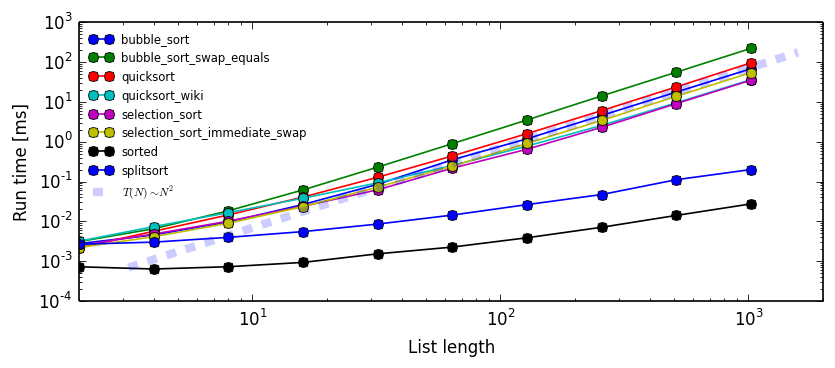

In [37]:
n = np.logspace(0.5, 3.2)
for algname, times in sorted(rt_small_ident.items()):
    plt.loglog(len_small, times, 'o-', label=algname)
plt.loglog(n, rt_small_ident['bubble_sort'][-3]*(n/len_small[-3])**2, 
           'b--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N^2$')
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2000)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

Two aspects of this curve are interesting: "Splitsort" is very fast (although not as fast as `sorted()`), while the bubble sort variant that swaps equals is noticeably slower than the normal bubble sort. The former can be explained by the fact that splitsort takes only a single step if all data is identical, the latter by the many unnecessary swaps.

#### Ascending values

In [38]:
rt_small_ascend = {algo.__name__:
                   [1000. * min(FunctionTimer(algo, test_data).auto_timeit(quiet=True))
                    for test_data in data_small['ascend']]
                   for algo in algos}

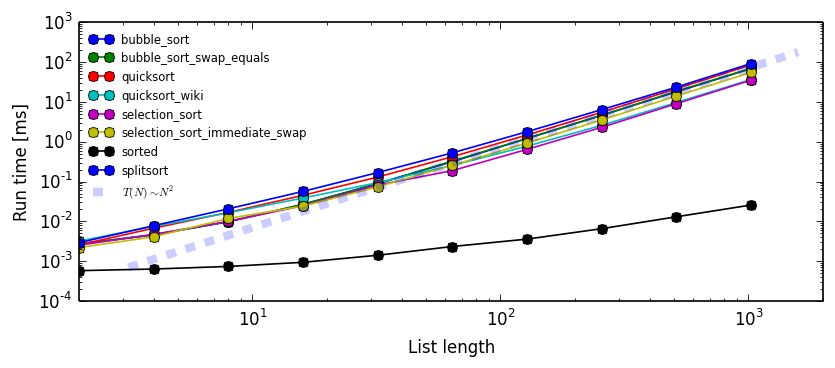

In [39]:
n = np.logspace(0.5, 3.2)
for algname, times in sorted(rt_small_ascend.items()):
    plt.loglog(len_small, times, 'o-', label=algname)
plt.loglog(n, rt_small_ascend['bubble_sort'][-3]*(n/len_small[-3])**2, 
           'b--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N^2$')
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2000)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

#### Descending values

In [40]:
rt_small_descend = {algo.__name__:
                    [1000. * min(FunctionTimer(algo, test_data).auto_timeit(quiet=True))
                     for test_data in data_small['descend']]
                    for algo in algos}

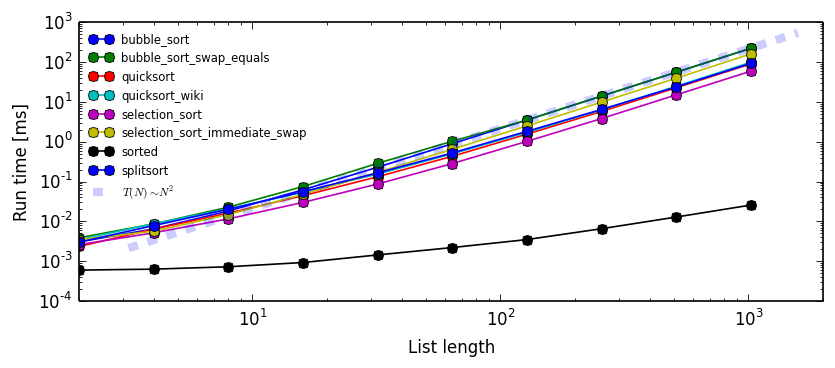

In [41]:
n = np.logspace(0.5, 3.2)
for algname, times in sorted(rt_small_descend.items()):
    plt.loglog(len_small, times, 'o-', label=algname)
plt.loglog(n, rt_small_descend['bubble_sort'][-3]*(n/len_small[-3])**2, 
           'b--', linewidth=5, alpha=0.2, label=r'$T(N) \sim N^2$')
plt.xlabel('List length')
plt.ylabel('Run time [ms]')
plt.xlim(0, 2000)
plt.legend(loc='upper left', frameon=False, fontsize='x-small');

#### Comparison of runtimes by structure of data

The graphs above show very clearly that quicksort behaves very differently for structured data than for random data: it becomes as bad as bubble sort and selection sort and scales linearly. The effects on the other algorithms are not so clearly visible. We therefore plot runtimes for each algorithm across all data sets.

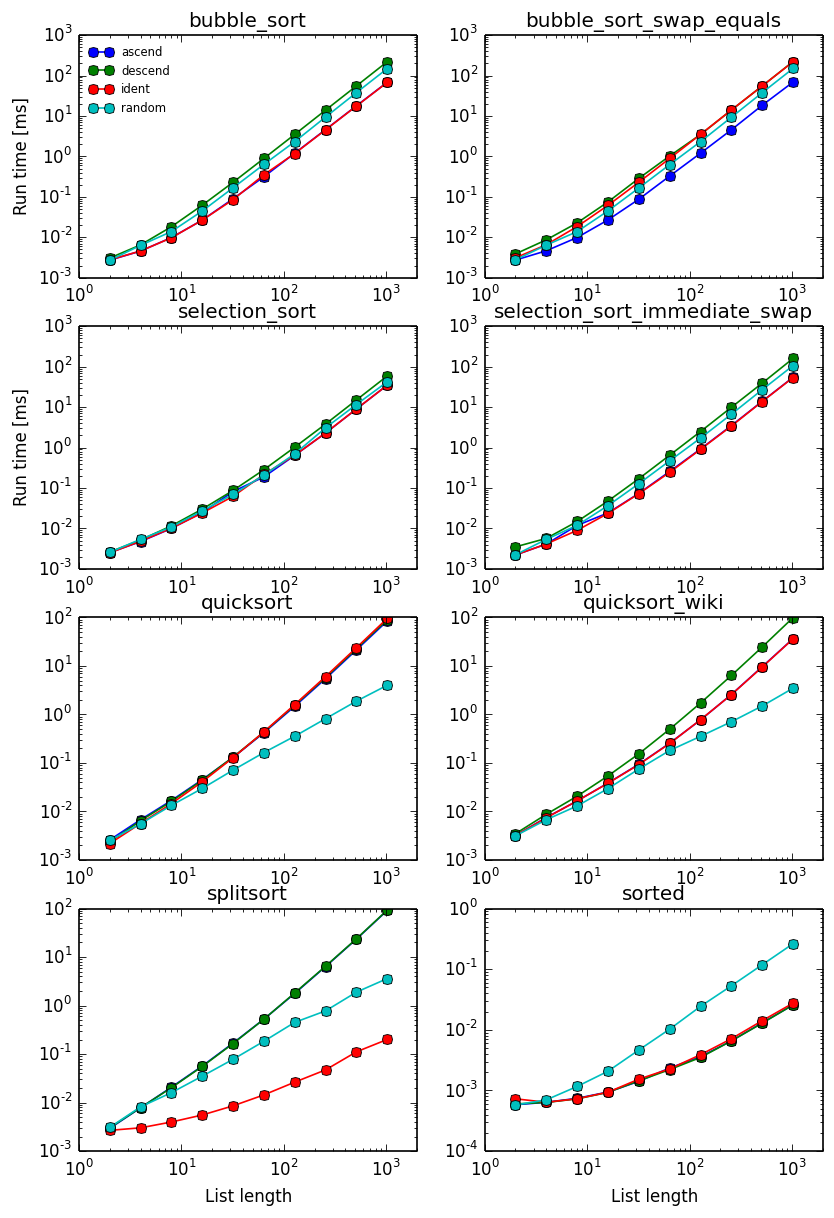

In [44]:
datasets = {'random': rt_small_random,
            'ident': rt_small_ident,
            'ascend': rt_small_ascend,
            'descend': rt_small_descend}

plt.figure(figsize=(8, 12))
for n, algo in enumerate(algos):
    plt.subplot(4, 2, n+1)
    for dataset, times in sorted(datasets.items()):
        plt.loglog(len_small, times[algo.__name__], 'o-', label=dataset)
        plt.xlim(1, 2000)

    if n < 3:
        plt.ylim(1e-3, 1e3)
    if n == 0:
        plt.legend(loc='upper left', frameon=False, fontsize='x-small');
    if n == 0 or n == 2:
        plt.ylabel('Run time [ms]')
    if n == 6 or n == 7:
        plt.xlabel('List length')
    plt.title(algo.__name__)

First of all, note the different vertical scale for the sorted plot. Also note that line figures now represent data sets, not algorithms.

Selection sort shows very similar runtime for all types of data. Only data sorted exactly opposite to the correct order appears so be sorted noticeably slower. For bubble sort, on the other hand, correctly sorted data is "sorted" somewhat faster than random data, which again is sorted faster than identical and inverted data. Observations for selection and bubble sort may be explained by the number of data swaps required: selection sort swaps each element at most once, and for descending data each element must be swapped over the maximal distance. Bubble sort, on the other hand, needs no swaps at all for sorted data, while inverted data requires a quadratic number of swaps. It is curious that the runtime for arrays of identical data is close to the runtime for inverse data. This may indicate a weakness in the implementation that forces unnecessary swaps.

Quicksort, including its wiki-variant and "splitsort", clearly performs extraordinarily badly for data that is structured, while it performs well on random data. This is easily explained by the fact that an efficient divide-and-conquer approach requires that the pivot element divides the data into approximately equal parts at reach recursion step. For ascending, descending and single-valued data, this is not given: the pivot is chosen so that all data ends on one side of it in each recursion step, making quicksort maximally inefficient.

The built-in `sorted()` clearly outperforms all our implementations. For random data, this is easily explained by the fact that it is a low-level function coded in C. For all other data types, its excellent performance indicates that it avoids the pivoting problems our quicksort incurs. 

## Conclusions

In this notebook, we have investigated the performance of several sorting functions implemented in Python and compared it to the built-in `sorted()` function. Testing on random data, we observed that run times for bubble and selection sort scale quadratically with problem size ($T(N)\sim N^2$), while quicksort and `sorted()` scale as $T(N)\sim N\ln N$, also as expected.

Bubble and selection sort perform roughly equally well for random and structured data (correctly sorted, inversly sorted, identical values), while quicksort exposes quadratic scaling for structured data. This even required us to raise Python's maximal recursion depth to allow benchmarking for $N=2^{10}$. Clearly, the pivoting strategy of our quicksort implementation is not robust against structure in the data.

The built-in `sorted()` function outperformed all our implementations and showed significantly better performance on structured than on random data. We do not know at present how `sorted()` achieves this.

Finally, we observed that our bubble sort implementation is as slow for lists containing identical values as it is for inversely sorted data. This may indicate that the algorithm unnecessarily swaps identical elements. We suggest a code review to find the cause of this behavior.

We recommend to use the built-in `sorted()` function in all practical work.